## Практические задания

**Задание 1.**

Необходимо собрать информацию о вакансиях на вводимую должность (используем input или через аргументы) с сайтов Superjob и HH. Приложение должно анализировать несколько страниц сайта (также вводим через input или аргументы). Получившийся список должен содержать в себе минимум:
Наименование вакансии.
Предлагаемую зарплату (отдельно минимальную и максимальную).
Ссылку на саму вакансию.
Сайт, откуда собрана вакансия. ### По желанию можно добавить ещё параметры вакансии (например, работодателя и расположение). Структура должна быть одинаковая для вакансий с обоих сайтов. Общий результат можно вывести с помощью dataFrame через pandas.

**Подключение библиотек и скриптов**

In [183]:
import requests
import json
from bs4 import BeautifulSoup
import lxml
import pandas as pd

**Вспомогательные переменные**

In [184]:
URL_HH = 'https://hh.ru'
URL_SJ = 'https://www.superjob.ru'
N_PAGES = 3

**Вспомогательные процедуры и функции**

In [220]:
def get_vacancy_HH(vacancy_name, pages = N_PAGES):
    
    GET_HH_REQUEST = URL_HH + '/search/vacancy?clusters=true&enable_snippets=true&salary=&st=searchVacancy&text=' + vacancy_name
    HEADER = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36'}
    
    data_list = []
    
    next_link = GET_HH_REQUEST
    
    i = 1
    
    while next_link != '' and i <= pages:
        
        i += 1
        
        data = requests.get(next_link, headers = HEADER)

        if data.ok:
            html = BeautifulSoup(data.text, 'lxml')
            
            tags = html.find_all('div', attrs={'class': 'vacancy-serp-item'})

            for tag in tags:

                name        = tag.find('a', attrs = {'data-qa': 'vacancy-serp__vacancy-title'}).text
                href        = tag.find('a', attrs = {'data-qa': 'vacancy-serp__vacancy-title'})['href']
                salary      = tag.find('span', attrs = {'data-qa': 'vacancy-serp__vacancy-compensation'})
                salary_from = '0'
                salary_to   = '0'

                if salary:

                    salary_list = salary.text.replace('\u202f', '').split(' ')

                    if 'от' in salary_list:
                        salary_from = salary_list[salary_list.index('от') + 1]
                    if 'до' in salary_list:
                        salary_to = salary_list[salary_list.index('до') + 1]

                    else:
                        if '–' in salary_list:
                            salary_to   = salary_list[salary_list.index('–') + 1]
                            salary_from = salary_list[0]

                    if salary_from == '' and salary_to == '':
                        salary_to = salary_list[0]

                salary_from = int(salary_from)
                salary_to   = int(salary_to)

                company = tag.find('div', attrs = {'class', 'vacancy-serp-item__meta-info-company'}).text.replace('\xa0', '')

                data_list.append(['HH.ru', name, href, company, salary_from, salary_to])
                
        #найдем следующую ссылку
        tag = html.find('a', attrs={'data-qa': 'pager-next'})
        
        next_link = ''
        
        if tag:
            next_link = URL_HH + tag['href']
            
            
        
    df = pd.DataFrame(data_list, columns = ['Resource', 'Name', 'link', 'Company', 'Salary (from)', 'Salary (to)'])
        
    return df

In [221]:
def get_vacancy_SJ(vacancy_name,  pages = N_PAGES):
    
    GET_SJ_REQUEST = URL_SJ + '/vacancy/search/?keywords=' + vacancy_name
    HEADER = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36'}
    
    data_list = []
    
    next_link = GET_SJ_REQUEST
    
    i = 1
    
    while next_link != '' and i <= pages:
        
        i += 1
        
        data = requests.get(next_link, headers = HEADER)

        if data.ok:
            html = BeautifulSoup(data.text, 'lxml')
            
            tags = html.find_all('div', attrs={'class': 'iJCa5 f-test-vacancy-item _1fma_ _2nteL'})

            for tag in tags:

                name_duty   = tag.find('div', attrs = {'class': '_1h3Zg _2rfUm _2hCDz _21a7u'})
                name        = name_duty.find('a').text
                
                href        = URL_SJ + tag.find('a')['href']
                
                salary      = tag.find('span', attrs = {'class': '_1h3Zg _2Wp8I _2rfUm _2hCDz _2ZsgW'})
                                
                salary_from = '0'
                salary_to   = '0'

                if salary:

                    salary_list = salary.text.replace('\u202f', '').replace('0\xa00', '00').replace('\xa0', ' ').split(' ')
                    
                    if 'от' in salary_list:
                        salary_from = salary_list[salary_list.index('от') + 1]
                    if 'до' in salary_list:
                        salary_to = salary_list[salary_list.index('до') + 1]

                    else:
                        if '—' in salary_list:
                            salary_to   = salary_list[salary_list.index('—') + 1]
                            salary_from = salary_list[0]##

                    if salary_from == '' and salary_to == '' and salary_list[0] != 'По':
                        salary_to = salary_list[0]

                salary_from = int(salary_from)
                salary_to   = int(salary_to)

                company_duty = tag.find('span', attrs = {'class', '_1h3Zg _3Fsn4 f-test-text-vacancy-item-company-name e5P5i _2hCDz _2ZsgW _2SvHc'})
                company = company_duty.find('a').text
                
                data_list.append(['SJ.ru', name, href, company, salary_from, salary_to])
                
        #найдем следующую ссылку
        tag = html.find('a', attrs={'rel': 'next'})
        
        next_link = ''
        
        if tag:
            next_link = URL_SJ + tag['href']
            
            
        
    df = pd.DataFrame(data_list, columns = ['Resource', 'Name', 'link', 'Company', 'Salary (from)', 'Salary (to)'])
        
    return df

In [232]:
df = pd.concat([get_vacancy_SJ('уполномоченный', 2), get_vacancy_SJ('уполномоченный', 2)])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 0 to 38
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Resource       78 non-null     object
 1   Name           78 non-null     object
 2   link           78 non-null     object
 3   Company        78 non-null     object
 4   Salary (from)  78 non-null     int64 
 5   Salary (to)    78 non-null     int64 
dtypes: int64(2), object(4)
memory usage: 4.3+ KB


<AxesSubplot:>

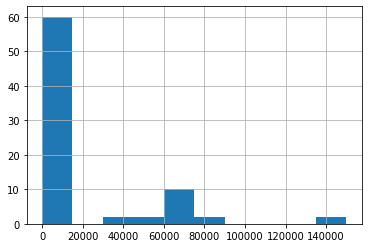

In [233]:
df['Salary (to)'].hist()